# Decision Trees

In [96]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
import seaborn as sns
import pandas as pd

from sklearn.datasets import make_blobs, load_breast_cancer, make_moons
from sklearn.metrics import euclidean_distances
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.utils import Bunch

from scipy import ndimage
from imageio import imread
import graphviz
import sys
from io import StringIO
import re

In [16]:
def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    # Define colors for each category
    color_cycle = ['#0000aa', '#ff2020', '#50ff50']  # Define specific colors

    # Handle the case where there is only one unique value
    if len(unique_y) == 1:
        single_color = color_cycle[0] if unique_y[0] == 0 else color_cycle[1]
        color_cycle = [single_color] * len(unique_y)

    for i, (yy, color) in enumerate(zip(unique_y, color_cycle)):
        mask = y == yy
        if c is None:
            current_color = color
        elif len(c) > 1:
            current_color = c[i]
        else:
            current_color = c
        
        if np.mean(colorConverter.to_rgb(current_color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, color=current_color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

In [54]:
def plot_tree_partition(X, y, tree, ax=None):
    cm3 = ListedColormap(['#0000aa', '#ff2020'])

    if ax is None:
        ax = plt.gca()
    eps = X.std() / 2.

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]

    Z = tree.predict(X_grid)
    Z = Z.reshape(X1.shape)
    faces = tree.apply(X_grid)
    faces = faces.reshape(X1.shape)
    border = ndimage.laplace(faces) != 0
    ax.contourf(X1, X2, Z, alpha=.4, cmap=cm3, levels=[0, .5, 1])
    ax.scatter(X1[border], X2[border], marker='.', s=1)

    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    return ax

In [112]:
def plot_trees(X, y, max_depth=1, ax=None):
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=0).fit(X, y)
    ax = plot_tree_partition(X, y, tree, ax=ax)
    ax.set_title("depth = %d" % max_depth)
    return tree

In [125]:
def plot_tree_progressive():
    X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
    plt.figure()
    ax = plt.gca()
    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
    plt.legend(["Class 0", "Class 1"], loc='best')

    axes = []
    for i in range(3):
        fig, ax = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={'xticks': (), 'yticks': ()})
        axes.append(ax)
    axes = np.array(axes)

    for i, max_depth in enumerate([1, 2, 9]):
        tree = plot_trees(X, y, max_depth=max_depth, ax=axes[i, 0])
        plot_tree(tree, feature_names=['Feature 0', 'Feature 1'], class_names=['Class 0', 'Class 1'], filled=True, ax=axes[i,1])
        axes[i, 1].set_axis_off()

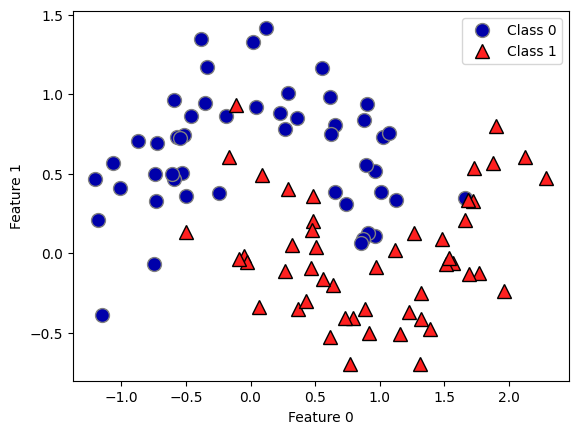

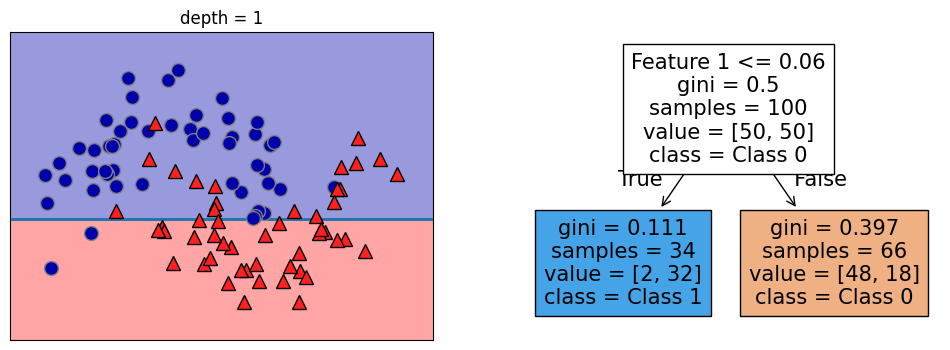

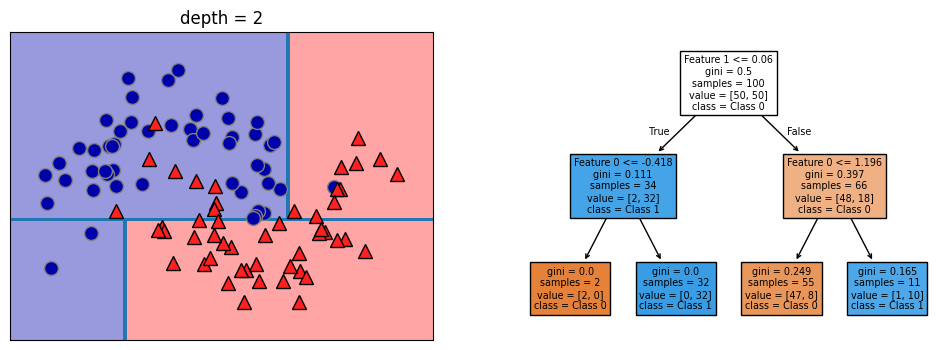

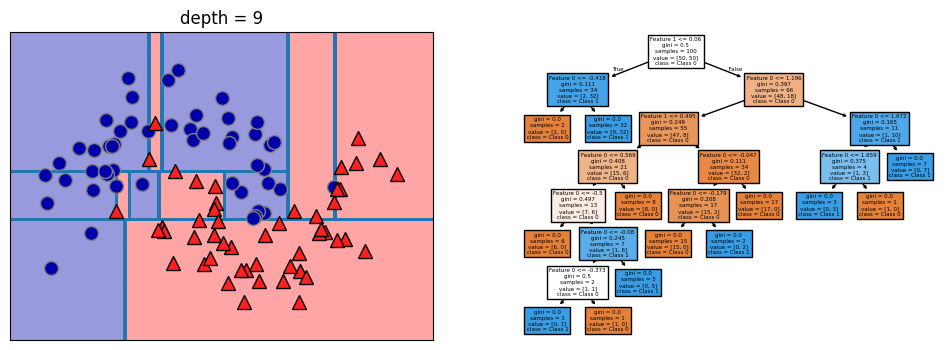

In [120]:
plot_tree_progressive()

### Dataset

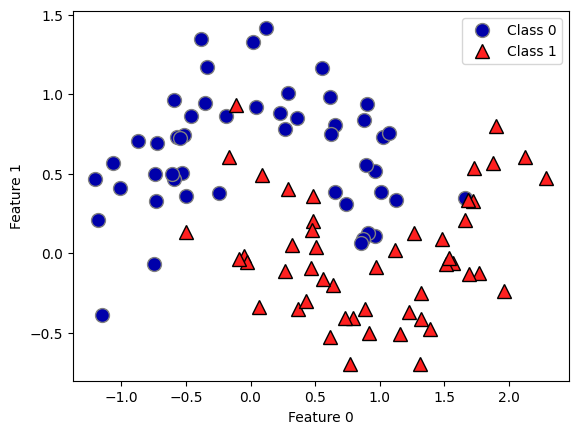

In [48]:
    X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
    plt.figure()
    ax = plt.gca()
    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
    plt.legend(["Class 0", "Class 1"], loc='best')

El algoritmo selecciona el punto que maximiza la reducción de la impureza, proporcionando la división que mejor separa las clases en los datos, para esto se van haciendo ramificaciones hasta el la hoja contenga solamente una clase en cada una de ellas, en ese momento es una hoja pura.

El índice de Gini es una medida de pureza utilizada en el contexto de los árboles de decisión para evaluar la calidad de una división de datos en cada nodo del árbol. Es una de las métricas que se pueden usar para decidir en qué punto dividir los datos en un árbol de decisión. Su objetivo es medir la "impureza" o "mezcla" de las clases en un nodo dado.

Gini = 1 − (pA^2 + pB^2)
Gini[1] = 1 - ((2/34)^2 + (32/34)^2)
Gini[1] = 0.11

Gini nos indica que existe un pequeña impuresa hacia un lado de las clases y una alta dominancia de una clase en comparación con la otra. Esto significa que la mayoría de los elementos en ese nodo pertenecen a la clase mayoritaria, lo que resulta en un nodo relativamente puro.
​
- **Índice de Gini Cercano a 0:** Un valor bajo del índice de Gini indica que el nodo es muy puro, es decir, la mayoría de las instancias en el nodo pertenecen a una sola clase. En tu caso, 0.112 es bajo, lo que sugiere que el nodo tiene una alta pureza con predominancia de una clase sobre otra.

- **Índice de Gini Cercano a 0.5:** Un valor cercano a 0.5 indica una impureza alta, lo que significa que las instancias en el nodo están distribuidas casi equitativamente entre las clases.

- **Índice de Gini Cercano a 1:** Un valor cercano a 1 indica que el nodo es completamente impuro, es decir, las instancias están distribuidas uniformemente entre las clases, lo que no proporciona una buena separación de clases.

Analizando los arboles de decision, al llegar al nodo 7 se cumple un gini de 0 en todos los niveles, por lo que utilizar un max_depth mayor a 7 ya no tendria caso, incluso un 7 ya es un overfitting para casos de este ejemplo.


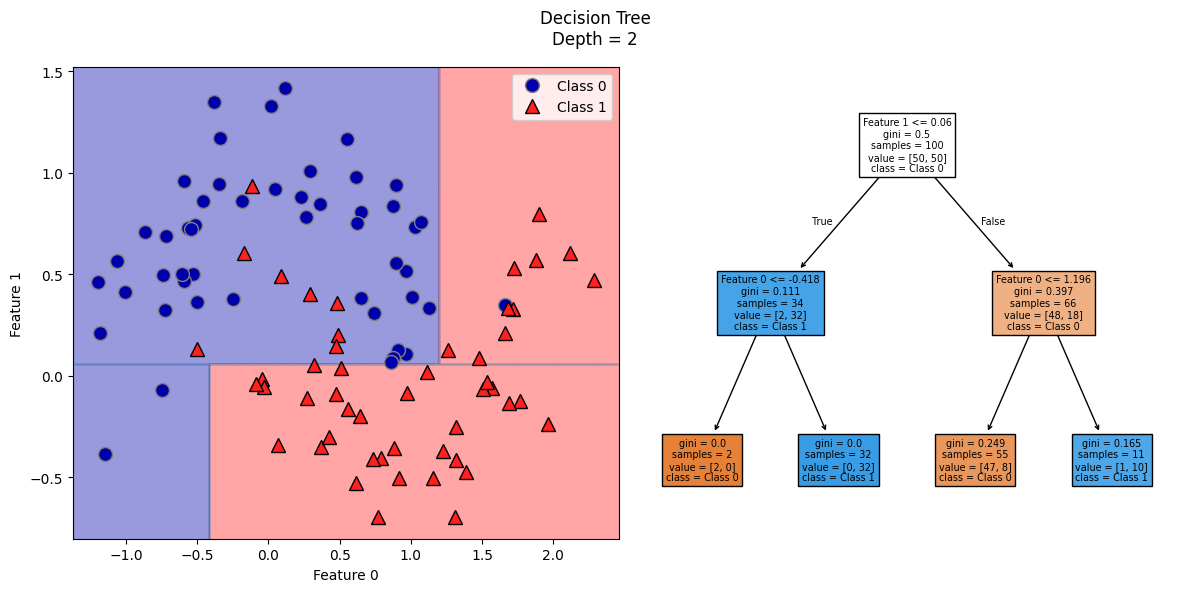

In [180]:
max_depth = 2

tree = DecisionTreeClassifier(max_depth=max_depth, random_state=0).fit(X, y)

cm3 = ListedColormap(['#0000aa', '#ff2020'])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 1000)
yy = np.linspace(y_min, y_max, 1000)

X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]


Z = tree.predict(X_grid)
Z = Z.reshape(X1.shape)
faces = tree.apply(X_grid)
faces = faces.reshape(X1.shape)
border = ndimage.laplace(faces) != 0

discrete_scatter(X[:, 0], X[:, 1], y, ax=ax[0])
plot_tree(tree, feature_names=['Feature 0', 'Feature 1'], class_names=['Class 0', 'Class 1'], filled=True, ax=ax[1])

ax[0].contourf(X1, X2, Z, alpha=.4, cmap=cm3, levels=[0, .5, 1])
ax[0].scatter(X1[border], X2[border], marker='.', s=0.01)
ax[0].set_ylabel('Feature 1')
ax[0].set_xlabel('Feature 0')
fig.suptitle("Decision Tree\nDepth = %d" % max_depth)
ax[0].legend(["Class 0", "Class 1"], loc='best')

plt.tight_layout()

    

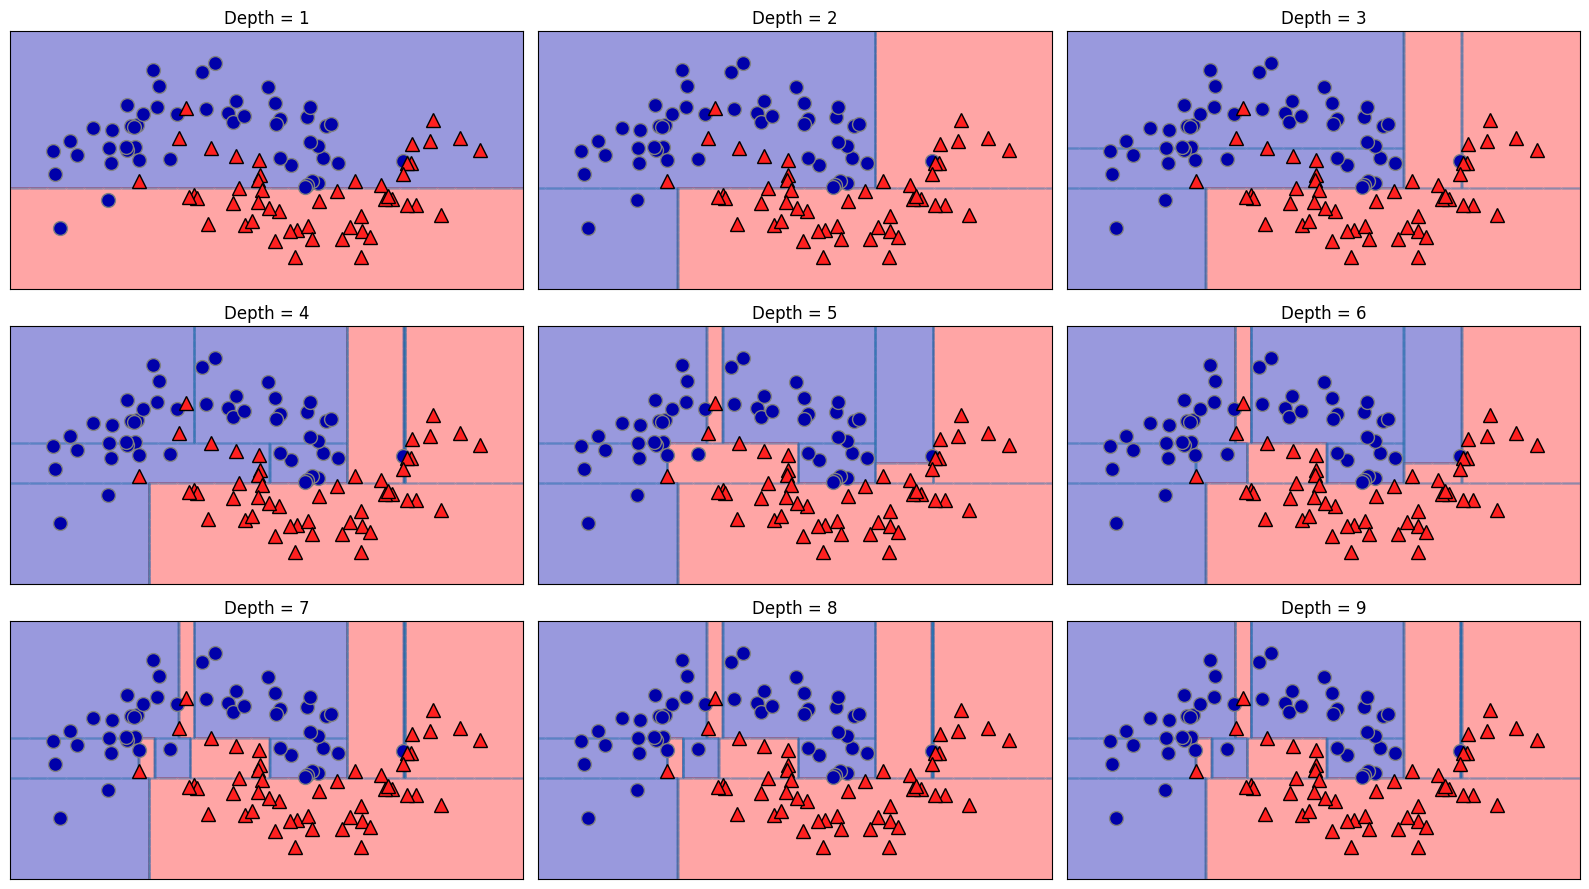

In [95]:
fig, axes = plt.subplots(3, 3, figsize=(16,9))
axes = axes.flatten()

cm3 = ListedColormap(['#0000aa', '#ff2020'])

max_depths = [1,2,3,4,5,6,7,8,9]

for max_depth, ax in zip(max_depths, axes):
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=0).fit(X, y)

    cm3 = ListedColormap(['#0000aa', '#ff2020'])

    eps = X.std() / 2.
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    

    Z = tree.predict(X_grid)
    Z = Z.reshape(X1.shape)
    faces = tree.apply(X_grid)
    faces = faces.reshape(X1.shape)
    border = ndimage.laplace(faces) != 0
    ax.contourf(X1, X2, Z, alpha=.4, cmap=cm3, levels=[0, .5, 1])
    ax.scatter(X1[border], X2[border], marker='.', s=0.01)
    ax.set_title("Depth = %d" % max_depth)
    

    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

plt.tight_layout()

## Pre-Puning y Post-Puning

Cuando dejamos crecer los arboles de decision hasta el final podemos llegar a un overfitting, ya que todos los nodos quedarian puros, incluos aquellos que se encuentren aislados enmedio de otra clase no correspondiente, lo que nos lleva a tener un accuracy del 100% para training set. Dos estrategias comunes para evitar el overfitting son:

- Pre-Puning: Parar la creación de mas nodos. Se pude limitar el max_depth, limitar el max_leaf_nodes, o requerir un min_samples_leaf para mantenerlo.
- Post-Puning: Remover los nodos que contienen poca información.

Scikit-learn solo permite pre-puning.

Vamos a revisar el comportamentiento del modelo sin ningun ajuste:

In [191]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


Limitando el crecimiento del arbol podemos llegar a un valor menor en el training set pero mucho mejor en el test set.

In [196]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


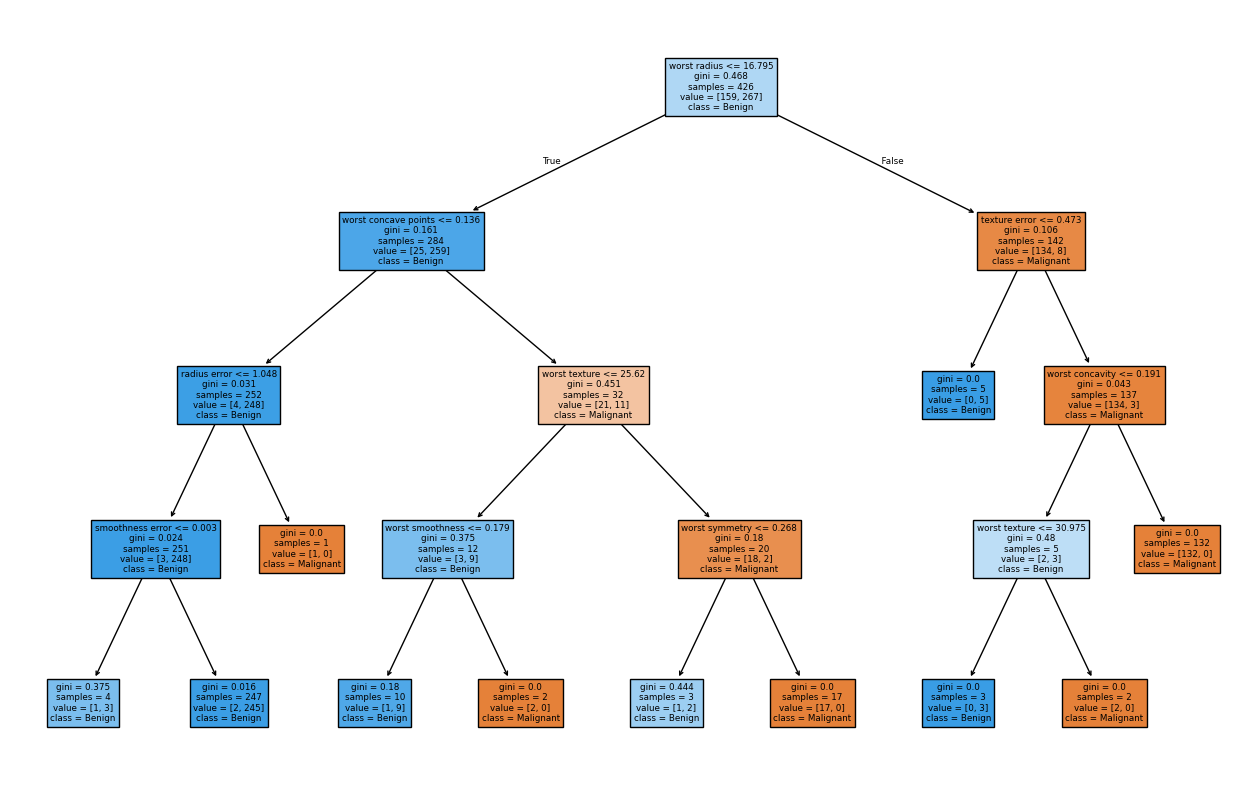

In [200]:
plt.figure(figsize=(16, 10))
plot_tree(tree, feature_names= cancer.feature_names, class_names=['Malignant', 'Benign'], filled=True)
plt.show()

En lugar de analizar el árbol de decisión completo, podemos centrarnos en la "Feature Importance" para entender qué características son más relevantes para predecir el objetivo. La "Feature Importance" indica la contribución relativa de cada característica en la toma de decisiones del modelo.

- Importancia de 0: La característica no se utilizó en el modelo.
- Importancia cercana a 1: La característica tiene una alta influencia en las predicciones.

La importancia de las características se normaliza para que la suma de todas sea igual a 1, facilitando la comparación. Una característica con alta importancia indica que contribuye significativamente a la reducción de la impureza del nodo, lo que mejora la capacidad predictiva del modelo.

En resumen, la "Feature Importance" nos muestra qué características son esenciales para el modelo, permitiéndonos interpretar y priorizar las variables más influyentes en la predicción.

In [201]:
print("Feature importances:")
print(tree.feature_importances_)

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


(-1.0, 30.0)

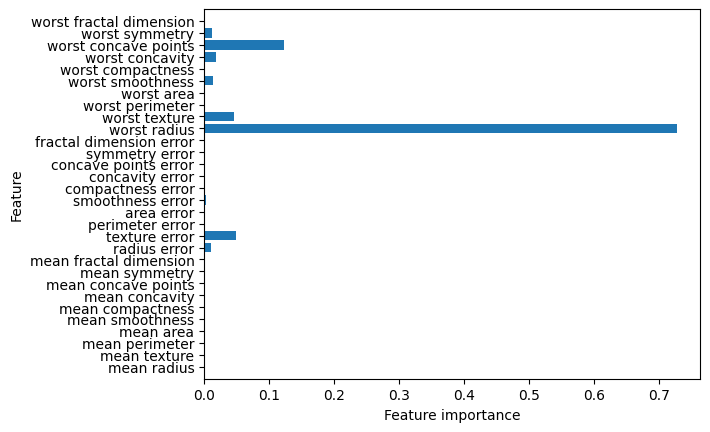

In [202]:
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), tree.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

## Decision Trees for Regression

Text(0, 0.5, 'Price in $/Mbyte')

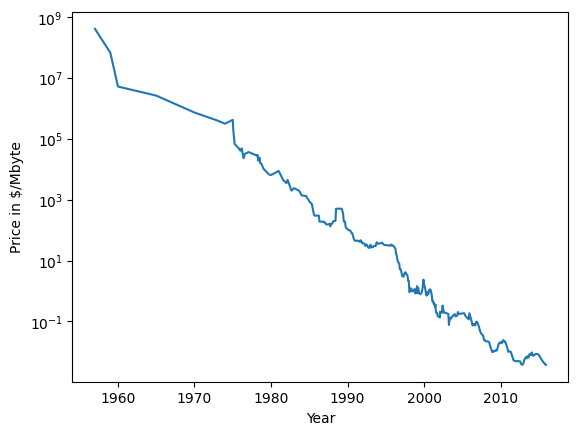

In [224]:
ram_prices = pd.read_csv("/Users/dylan.velo/OneDrive - Softtek/Documents/Machine Learning/ram_price.csv")

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")

Al comparar un modelo lineal con una regresión utilizando un árbol de decisión, observamos diferencias clave en sus capacidades predictivas. El modelo lineal es capaz de extrapolar más allá del rango de datos históricos y ofrece predicciones razonables para valores futuros, extendiendo las tendencias observadas. En contraste, el árbol de decisión se ajusta muy bien a los datos de entrenamiento, generando una predicción precisa dentro del rango de datos que ha visto. Sin embargo, fuera del rango de los datos de entrenamiento, el árbol de decisión no extrapola; en su lugar, tiende a predecir el valor promedio del último nodo hoja que ha visto, lo que limita su capacidad de ofrecer nuevas predicciones útiles para datos no observados previamente.

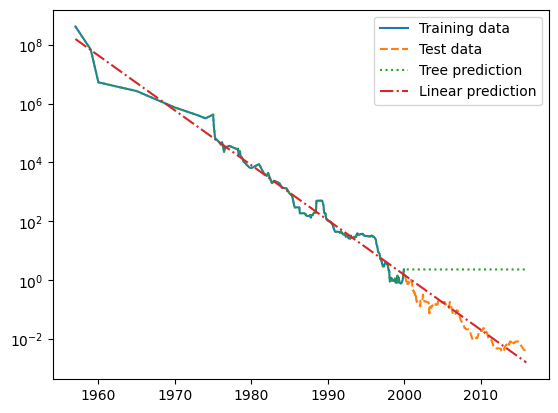

In [235]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
# use historical data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# predict prices based on date
X_train = data_train.date.values.reshape(-1, 1)
# we use a log-transform to get a simpler relationship of data to target
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# predict on all data
X_all = ram_prices.date.values.reshape(-1, 1)

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# undo log-transform
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, linestyle = '--', label="Test data")
plt.semilogy(ram_prices.date, price_tree, linestyle = ':', label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, linestyle = '-.', label="Linear prediction")
plt.legend()